In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import copy


Завантаження даних

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_PATH = Path('/content/')
PROCESSED_FILE = DATA_PATH / 'processed_data_with_all_features.csv'

df = pd.read_csv(PROCESSED_FILE)
print(f"Розмір датасету: {df.shape}")
print(f"\nКолонки: {df.columns.tolist()}")

print(f"\nРозподіл по квадрантах:")
print(df['emotion_quadrant'].value_counts())

Mounted at /content/drive
Розмір датасету: (2000, 79)

Колонки: ['Audio_Song', 'Lyric_Song', 'Quadrant', 'AllMusic Id', 'AllMusic Extraction Date', 'Artist', 'Title', 'Relevance', 'Year', 'LowestYear', 'Duration', 'Moods', 'MoodsAll', 'MoodsAllWeights', 'Genres', 'GenreWeights', 'Themes', 'ThemeWeights', 'Styles', 'StyleWeights', 'AppearancesTrackIDs', 'AppearancesAlbumIDs', 'Sample', 'SampleURL', 'ActualYear', 'num_Genres', 'num_MoodsAll', 'Arousal', 'Valence', 'emotion_quadrant', 'lyrics_raw', 'lyrics_length', 'lyrics_processed', 'lyrics_tokens', 'num_tokens', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'chroma_mean', 'chroma_std', 'spectr

Підготовка даних

In [ ]:
audio_features = [col for col in df.columns if any(x in col for x in
                  ['mfcc', 'chroma', 'spectral', 'tempo', 'zcr', 'rms',
                   'harmonic', 'percussive', 'mel', 'duration'])]

text_features = [col for col in df.columns if 'lyrics' in col]

print(f"\nАудіо features: {len(audio_features)}")
print(f"Текстові features: {len(text_features)}")

le = LabelEncoder()
df['emotion_label'] = le.fit_transform(df['emotion_quadrant'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

df_clean = df.dropna(subset=['emotion_quadrant', 'lyrics_processed'])

for col in audio_features:
    if col in df_clean.columns:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)


Аудіо features: 44
Текстові features: 4


TRAIN/VAL/TEST SPLIT

In [ ]:
print(f"Колонки в df_clean: {df_clean.columns.tolist()[:10]}...")

train_file = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_train_bimodal_balanced.csv'
val_file = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_validate_bimodal_balanced.csv'
test_file = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_test_bimodal_balanced.csv'

if train_file.exists():
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    test_df = pd.read_csv(test_file)

    print(f"Колонки в train_df: {train_df.columns.tolist()}")

    if 'Song' in train_df.columns:
        train_data = df_clean[df_clean['Audio_Song'].isin(train_df['Song'])].copy()
        val_data = df_clean[df_clean['Audio_Song'].isin(val_df['Song'])].copy()
        test_data = df_clean[df_clean['Audio_Song'].isin(test_df['Song'])].copy()
        print(f"Train matches: {len(train_data)}, Val matches: {len(val_data)}, Test matches: {len(test_data)}")

        if len(train_data) == 0:
            train_data = df_clean[df_clean['Lyric_Song'].isin(train_df['Song'])].copy()
            val_data = df_clean[df_clean['Lyric_Song'].isin(val_df['Song'])].copy()
            test_data = df_clean[df_clean['Lyric_Song'].isin(test_df['Song'])].copy()
            print(f"Train matches: {len(train_data)}, Val matches: {len(val_data)}, Test matches: {len(test_data)}")

        if len(train_data) == 0 or len(val_data) == 0 or len(test_data) == 0:
            train_data, temp_data = train_test_split(df_clean, test_size=0.3,
                                                     stratify=df_clean['emotion_label'],
                                                     random_state=42)
            val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                                   stratify=temp_data['emotion_label'],
                                                   random_state=42)
    else:
        train_data, temp_data = train_test_split(df_clean, test_size=0.3,
                                                 stratify=df_clean['emotion_label'],
                                                 random_state=42)
        val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                               stratify=temp_data['emotion_label'],
                                               random_state=42)
else:
    train_data, temp_data = train_test_split(df_clean, test_size=0.3,
                                             stratify=df_clean['emotion_label'],
                                             random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                           stratify=temp_data['emotion_label'],
                                           random_state=42)

print(f"\nTrain size: {len(train_data)} ({len(train_data)/len(df_clean)*100:.1f}%)")
print(f"Val size: {len(val_data)} ({len(val_data)/len(df_clean)*100:.1f}%)")
print(f"Test size: {len(test_data)} ({len(test_data)/len(df_clean)*100:.1f}%)")

print("\nРозподіл класів:")
print("Train:", train_data['emotion_quadrant'].value_counts().to_dict())
print("Val:", val_data['emotion_quadrant'].value_counts().to_dict())
print("Test:", test_data['emotion_quadrant'].value_counts().to_dict())

Колонки в df_clean: ['Audio_Song', 'Lyric_Song', 'Quadrant', 'AllMusic Id', 'AllMusic Extraction Date', 'Artist', 'Title', 'Relevance', 'Year', 'LowestYear']...

Train size: 1400 (70.0%)
Val size: 300 (15.0%)
Test size: 300 (15.0%)

Розподіл класів:
Train: {'Q2_Angry_Tense': 350, 'Q3_Sad_Depressed': 350, 'Q1_Happy_Excited': 350, 'Q4_Calm_Relaxed': 350}
Val: {'Q3_Sad_Depressed': 75, 'Q4_Calm_Relaxed': 75, 'Q1_Happy_Excited': 75, 'Q2_Angry_Tense': 75}
Test: {'Q4_Calm_Relaxed': 75, 'Q3_Sad_Depressed': 75, 'Q2_Angry_Tense': 75, 'Q1_Happy_Excited': 75}


In [ ]:
class Config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    EPOCHS = 10
    LEARNING_RATE = 1e-5

    DATA_PATH = Path('/content/')
    FILE_NAME = 'processed_data_with_all_features.csv'
    FULL_PATH = DATA_PATH / FILE_NAME

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv(Config.FULL_PATH)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['label_encoded', 'cluster', 'kmeans_label', 'Unnamed: 0']
if 'emotion_quadrant' in numeric_cols: exclude_cols.append('emotion_quadrant')

audio_feature_cols = [c for c in numeric_cols if c not in exclude_cols]

nan_count = df[audio_feature_cols].isna().sum().sum()

if nan_count > 0:
    df[audio_feature_cols] = df[audio_feature_cols].fillna(df[audio_feature_cols].mean())
    df[audio_feature_cols] = df[audio_feature_cols].fillna(0)

text_col = 'lyrics_raw'
if text_col not in df.columns:
     text_col = [c for c in df.columns if 'lyric' in c.lower()][0]

print(f"Текстова колонка: {text_col}")
print(f"Кількість аудіо ознак: {len(audio_feature_cols)}")

target_col = 'emotion_quadrant'
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[target_col])

scaler = StandardScaler()
df[audio_feature_cols] = scaler.fit_transform(df[audio_feature_cols])

if np.isnan(df[audio_feature_cols].values).any():
    df[audio_feature_cols] = df[audio_feature_cols].fillna(0)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_encoded'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


Текстова колонка: lyrics_raw
Кількість аудіо ознак: 53


Audio model:

Epoch 1/50 | Train Loss: 1.3944 | Val Loss: 1.3345 | F1: 0.4331
Epoch 2/50 | Train Loss: 1.2743 | Val Loss: 1.0433 | F1: 0.6053
Epoch 3/50 | Train Loss: 1.0925 | Val Loss: 0.8790 | F1: 0.6677
Epoch 4/50 | Train Loss: 1.0370 | Val Loss: 0.8465 | F1: 0.6534
Epoch 5/50 | Train Loss: 0.9394 | Val Loss: 0.7411 | F1: 0.7338
Epoch 6/50 | Train Loss: 0.9100 | Val Loss: 0.7587 | F1: 0.7357
Epoch 7/50 | Train Loss: 0.8697 | Val Loss: 0.6720 | F1: 0.7501
Epoch 8/50 | Train Loss: 0.6885 | Val Loss: 0.5589 | F1: 0.7871
Epoch 9/50 | Train Loss: 0.6676 | Val Loss: 0.3752 | F1: 0.8861
Epoch 10/50 | Train Loss: 0.4975 | Val Loss: 0.2383 | F1: 0.9328
Epoch 11/50 | Train Loss: 0.4868 | Val Loss: 0.1845 | F1: 0.9598
Epoch 12/50 | Train Loss: 0.4027 | Val Loss: 0.1833 | F1: 0.9545
Epoch 13/50 | Train Loss: 0.3622 | Val Loss: 0.1310 | F1: 0.9624
Epoch 14/50 | Train Loss: 0.3906 | Val Loss: 0.1351 | F1: 0.9627
Epoch 15/50 | Train Loss: 0.4028 | Val Loss: 0.1079 | F1: 0.9724
Epoch 16/50 | Train Loss: 0.3341 |

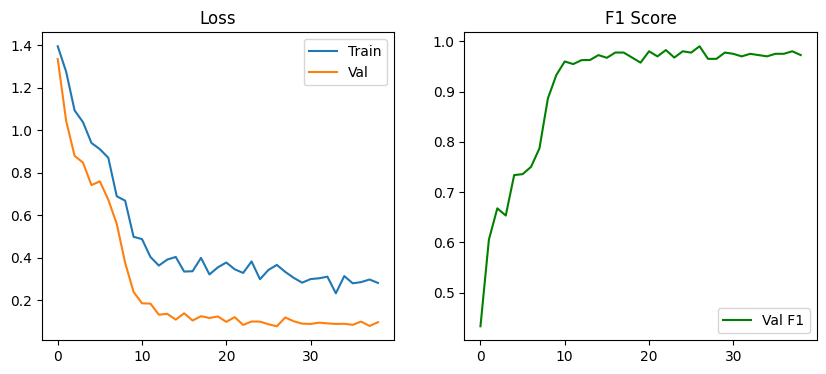

                  precision    recall  f1-score   support

Q1_Happy_Excited       0.99      1.00      1.00       100
  Q2_Angry_Tense       0.98      1.00      0.99       100
Q3_Sad_Depressed       0.99      0.98      0.98       100
 Q4_Calm_Relaxed       1.00      0.98      0.99       100

        accuracy                           0.99       400
       macro avg       0.99      0.99      0.99       400
    weighted avg       0.99      0.99      0.99       400



In [ ]:
def mixup_data(x_audio, x_ids, x_mask, x_token, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_audio.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_audio = lam * x_audio + (1 - lam) * x_audio[index, :]

    y_a, y_b = y, y[index]
    return mixed_audio, x_ids, x_mask, x_token, y_a, y_b, lam, index

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class AudioMLP(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(128, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.GELU()
        )
    def forward(self, x):
        return self.net(x)

class RobustModel(nn.Module):
    def __init__(self, num_classes, audio_input_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-1:].parameters():
            param.requires_grad = True

        self.audio_encoder = AudioMLP(audio_input_dim, output_dim=128)

        self.fusion_dim = 128
        self.text_proj = nn.Linear(768, self.fusion_dim)
        self.audio_proj = nn.Linear(128, self.fusion_dim)
        self.attention = nn.Linear(self.fusion_dim * 2, 1)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.fusion_dim, num_classes)
        )

    def forward(self, ids, mask, token_type_ids, audio_features):
        bert_out = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        text_emb = bert_out.pooler_output # [Batch, 768]
        text_proj = torch.tanh(self.text_proj(text_emb))

        audio_proj = torch.tanh(self.audio_encoder(audio_features))

        concat = torch.cat([text_proj, audio_proj], dim=1)
        weights = torch.sigmoid(self.attention(concat))

        fused = weights * text_proj + (1 - weights) * audio_proj

        return self.classifier(fused)

model = RobustModel(num_classes=len(le.classes_), audio_input_dim=len(audio_feature_cols))
model.to(device)

y_train_indices = train_df['label_encoded'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

EPOCHS = 50
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(training_loader), epochs=EPOCHS)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 12
counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for data in training_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        audio_features = data['audio_features'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()

        if np.random.random() > 0.5:
            mixed_audio, _, _, _, y_a, y_b, lam, idx = mixup_data(audio_features, ids, mask, token_type_ids, targets)

            outputs = model(ids, mask, token_type_ids, mixed_audio)

            loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)
        else:
            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in testing_loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            audio_features = data['audio_features'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            fin_targets.extend(targets.cpu().tolist())
            fin_outputs.extend(predicted.cpu().tolist())

    avg_train_loss = total_loss / len(training_loader)
    avg_val_loss = val_loss / len(testing_loader)
    val_f1 = f1_score(fin_targets, fin_outputs, average='weighted')
    val_acc = accuracy_score(fin_targets, fin_outputs)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping.")
            break

print(f"\nBest Weighted F1: {best_f1:.4f}")
model.load_state_dict(best_model_wts)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Val F1', color='green')
plt.title('F1 Score')
plt.legend()
plt.show()

model.eval()
fin_targets = []
fin_outputs = []
with torch.no_grad():
    for data in testing_loader:
        outputs = model(data['ids'].to(device), data['mask'].to(device),
                       data['token_type_ids'].to(device), data['audio_features'].to(device))
        _, predicted = torch.max(outputs, 1)
        fin_targets.extend(data['targets'].tolist())
        fin_outputs.extend(predicted.tolist())

print(classification_report(fin_targets, fin_outputs, target_names=le.classes_))

Text model:

Epoch 1/25 | Train Loss: 0.8929 | Val Loss: 0.8381 | Acc: 0.2425 | F1: 0.1537
  → New best F1: 0.1537
Epoch 2/25 | Train Loss: 0.8663 | Val Loss: 0.7855 | Acc: 0.2475 | F1: 0.1895
  → New best F1: 0.1895
Epoch 3/25 | Train Loss: 0.8307 | Val Loss: 0.7578 | Acc: 0.3625 | F1: 0.3177
  → New best F1: 0.3177
Epoch 4/25 | Train Loss: 0.8180 | Val Loss: 0.7260 | Acc: 0.4250 | F1: 0.4006
  → New best F1: 0.4006
Epoch 5/25 | Train Loss: 0.7822 | Val Loss: 0.6948 | Acc: 0.4400 | F1: 0.4333
  → New best F1: 0.4333
Epoch 6/25 | Train Loss: 0.7438 | Val Loss: 0.6488 | Acc: 0.4775 | F1: 0.4666
  → New best F1: 0.4666
Epoch 7/25 | Train Loss: 0.7158 | Val Loss: 0.6035 | Acc: 0.5200 | F1: 0.5200
  → New best F1: 0.5200
Epoch 8/25 | Train Loss: 0.6568 | Val Loss: 0.5467 | Acc: 0.5650 | F1: 0.5659
  → New best F1: 0.5659
Epoch 9/25 | Train Loss: 0.6042 | Val Loss: 0.4969 | Acc: 0.6000 | F1: 0.5947
  → New best F1: 0.5947
Epoch 10/25 | Train Loss: 0.5482 | Val Loss: 0.4505 | Acc: 0.6325 | F1: 0.6262
  →

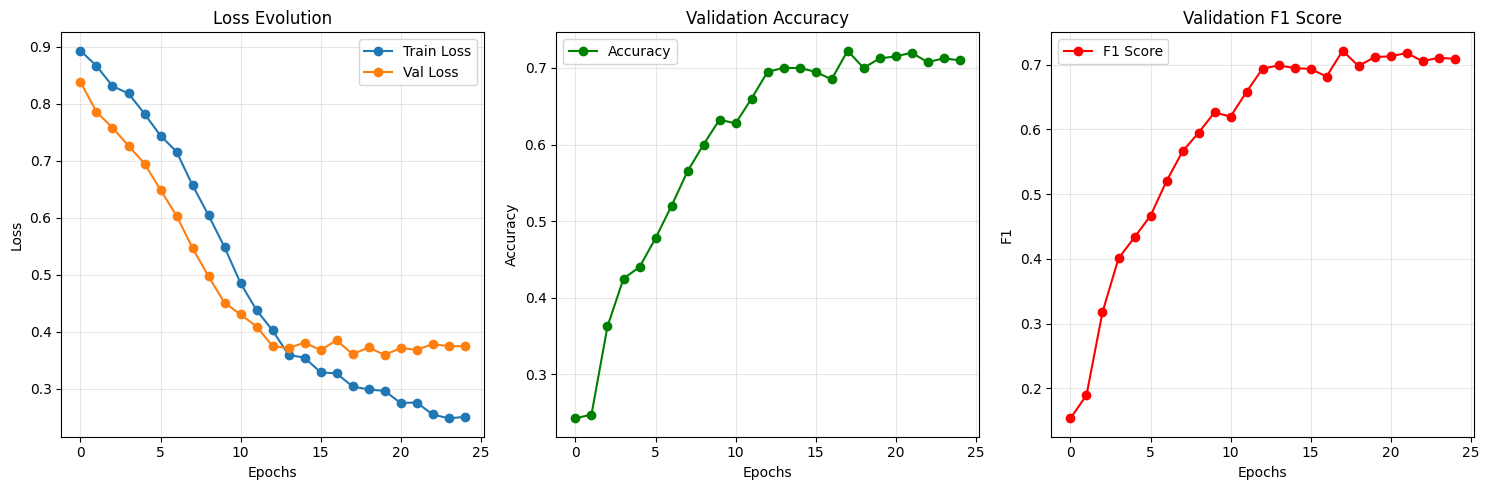

                  precision    recall  f1-score   support

Q1_Happy_Excited     0.7273    0.6095    0.6632       105
  Q2_Angry_Tense     0.8208    0.8529    0.8365       102
Q3_Sad_Depressed     0.7083    0.7083    0.7083        96
 Q4_Calm_Relaxed     0.6364    0.7216    0.6763        97

        accuracy                         0.7225       400
       macro avg     0.7232    0.7231    0.7211       400
    weighted avg     0.7245    0.7225    0.7214       400



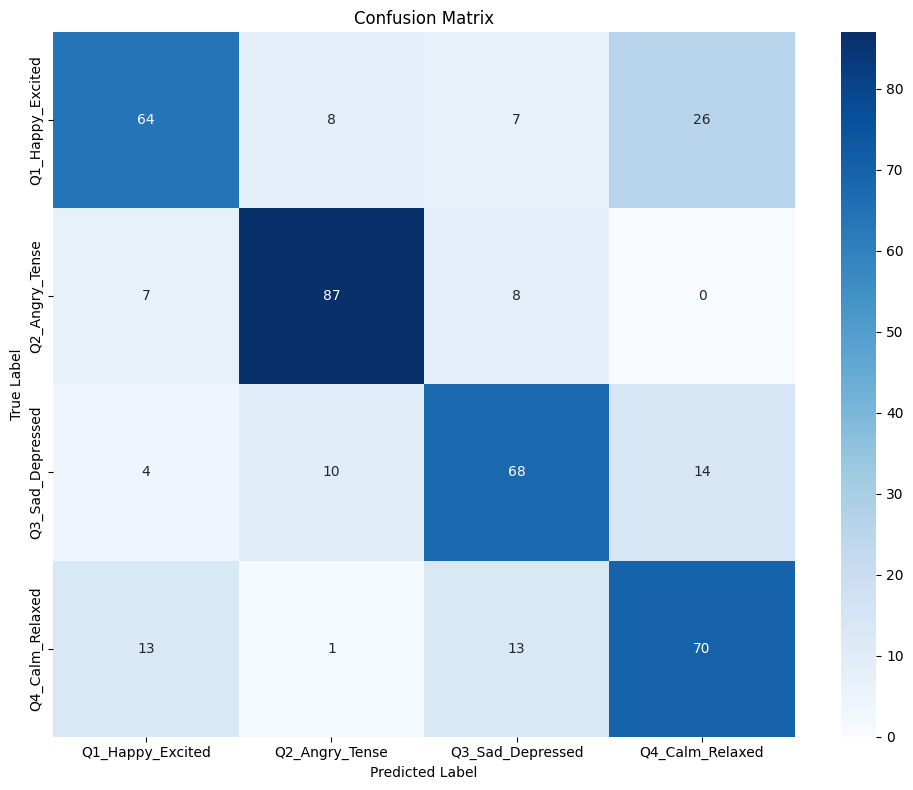

In [8]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

BATCH_SIZE = 32
MAX_LEN = 256
EPOCHS = 25
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500
GRAD_ACCUMULATION_STEPS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FULL_PATH = '/content/processed_data_with_all_features.csv'
df = pd.read_csv(FULL_PATH)

text_col = 'lyrics_raw' if 'lyrics_raw' in df.columns else 'lyrics'
target_col = 'emotion_quadrant'

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[target_col])

group_col = 'Audio_Song' if 'Audio_Song' in df.columns else 'filename'
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(df, groups=df[group_col]))

train_df = df.iloc[train_idxs].reset_index(drop=True)
test_df = df.iloc[test_idxs].reset_index(drop=True)

class EnhancedTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, text_col, augment=False):
        self.tokenizer = tokenizer
        self.text = dataframe[text_col].astype(str).tolist()
        self.targets = dataframe['label_encoded'].values
        self.max_len = max_len
        self.augment = augment

    def __len__(self):
        return len(self.text)

    def random_mask_words(self, text, mask_prob=0.1):
        words = text.split()
        if len(words) < 3:
            return text

        n_mask = max(1, int(len(words) * mask_prob))
        mask_indices = np.random.choice(len(words), n_mask, replace=False)

        for idx in mask_indices:
            words[idx] = '[MASK]'

        return ' '.join(words)

    def __getitem__(self, index):
        text = self.text[index]
        text = " ".join(text.split())

        if self.augment and np.random.random() > 0.7:
            text = self.random_mask_words(text)

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'ids': inputs['input_ids'].flatten(),
            'mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

class ImprovedTextBERT(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        for param in self.bert.parameters():
            param.requires_grad = False

        for param in self.bert.encoder.layer[-4:].parameters():
            param.requires_grad = True

        for param in self.bert.pooler.parameters():
            param.requires_grad = True

        self.attention = nn.MultiheadAttention(
            embed_dim=768,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(256, num_classes)
        )

        self.cls_projection = nn.Linear(768, 768)

    def forward(self, ids, mask, token_type_ids):
        output = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True
        )

        sequence_output = output.last_hidden_state

        attended_output, _ = self.attention(
            sequence_output,
            sequence_output,
            sequence_output,
            key_padding_mask=~mask.bool()
        )

        cls_output = attended_output[:, 0, :]

        cls_output = cls_output + self.cls_projection(output.pooler_output)

        logits = self.classifier(cls_output)

        return logits

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight

    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_preds = F.log_softmax(pred, dim=-1)

        # Smooth labels
        targets = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
        targets = (1 - self.epsilon) * targets + self.epsilon / n_classes

        loss = (-targets * log_preds).sum(dim=-1)

        if self.weight is not None:
            loss = loss * self.weight[target]

        return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

training_set = EnhancedTextDataset(train_df, tokenizer, MAX_LEN, text_col, augment=True)
testing_set = EnhancedTextDataset(test_df, tokenizer, MAX_LEN, text_col, augment=False)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testing_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = ImprovedTextBERT(num_classes=len(le.classes_), dropout=0.3)
model.to(device)

y_train = train_df['label_encoded'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = AdamW([
    {'params': model.bert.encoder.layer[-4:].parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.bert.pooler.parameters(), 'lr': LEARNING_RATE * 0.5},
    {'params': model.attention.parameters(), 'lr': LEARNING_RATE},
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE},
    {'params': model.cls_projection.parameters(), 'lr': LEARNING_RATE}
], lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(training_loader) * EPOCHS // GRAD_ACCUMULATION_STEPS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 8
counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, data in enumerate(training_loader):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        loss = loss / GRAD_ACCUMULATION_STEPS

        loss.backward()

        if (step + 1) % GRAD_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUMULATION_STEPS

    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in testing_loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            fin_targets.extend(targets.cpu().tolist())
            fin_outputs.extend(predicted.cpu().tolist())

    avg_train_loss = total_loss / len(training_loader)
    avg_val_loss = val_loss / len(testing_loader)
    val_f1 = f1_score(fin_targets, fin_outputs, average='weighted')
    val_acc = accuracy_score(fin_targets, fin_outputs)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        torch.save(model.state_dict(), 'best_text_model_improved.pth')
        print(f"  → New best F1: {best_f1:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping!")
            break

print(f"\nText-Only Best F1: {best_f1:.4f}")
model.load_state_dict(best_model_wts)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], color='green', label='Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], color='red', label='F1 Score', marker='o')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

model.eval()
fin_targets = []
fin_outputs = []
fin_probs = []

with torch.no_grad():
    for data in testing_loader:
        outputs = model(
            data['ids'].to(device),
            data['mask'].to(device),
            data['token_type_ids'].to(device)
        )

        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        fin_targets.extend(data['targets'].tolist())
        fin_outputs.extend(predicted.cpu().tolist())
        fin_probs.extend(probs.cpu().numpy())

print(classification_report(fin_targets, fin_outputs, target_names=le.classes_, digits=4))

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(fin_targets, fin_outputs)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

**Combined model:**

Epoch 1/40 | Train Loss: 1.3965 | Val Loss: 1.3811 | Acc: 0.2700 | F1: 0.2164
Epoch 2/40 | Train Loss: 1.3875 | Val Loss: 1.3639 | Acc: 0.3700 | F1: 0.3407
Epoch 3/40 | Train Loss: 1.3576 | Val Loss: 1.3043 | Acc: 0.5300 | F1: 0.5153
Epoch 4/40 | Train Loss: 1.2768 | Val Loss: 1.1221 | Acc: 0.5975 | F1: 0.5815
Epoch 5/40 | Train Loss: 1.1326 | Val Loss: 0.9443 | Acc: 0.6500 | F1: 0.6397
Epoch 6/40 | Train Loss: 1.1152 | Val Loss: 0.9056 | Acc: 0.6650 | F1: 0.6601
Epoch 7/40 | Train Loss: 1.0834 | Val Loss: 0.8315 | Acc: 0.6975 | F1: 0.6981
Epoch 8/40 | Train Loss: 0.9496 | Val Loss: 0.8019 | Acc: 0.7050 | F1: 0.7039
Epoch 9/40 | Train Loss: 0.9971 | Val Loss: 0.8375 | Acc: 0.6875 | F1: 0.6823
Epoch 10/40 | Train Loss: 0.8492 | Val Loss: 0.7896 | Acc: 0.6575 | F1: 0.6523
Epoch 11/40 | Train Loss: 0.8066 | Val Loss: 0.7307 | Acc: 0.7225 | F1: 0.7231
Epoch 12/40 | Train Loss: 0.8501 | Val Loss: 0.6991 | Acc: 0.7450 | F1: 0.7427
Epoch 13/40 | Train Loss: 0.6842 | Val Loss: 0.7641 | Acc: 0.

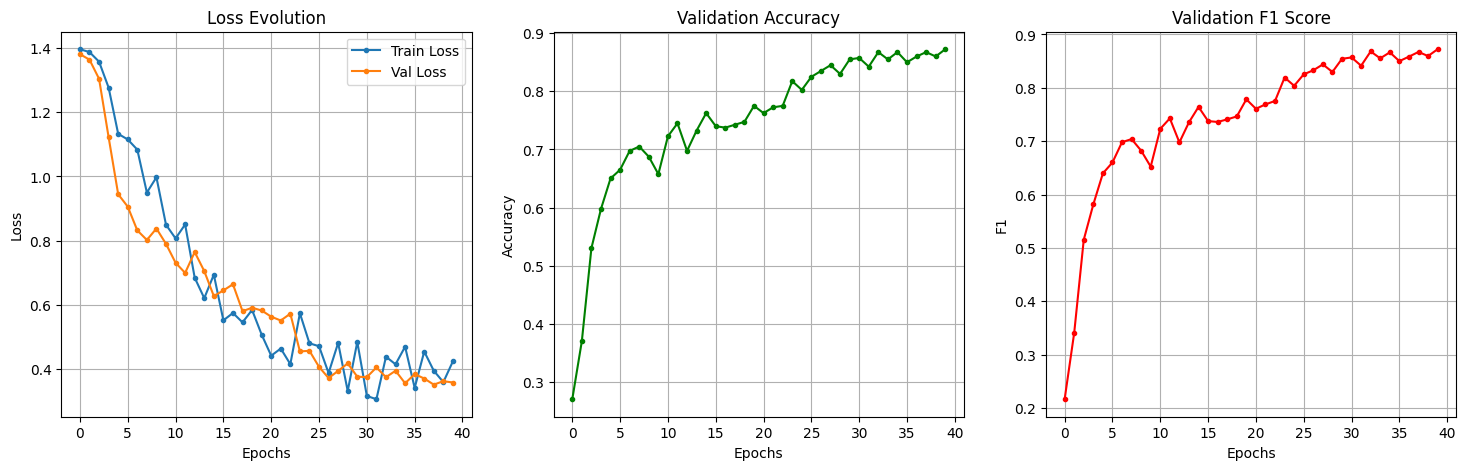

                  precision    recall  f1-score   support

Q1_Happy_Excited       0.86      0.90      0.88       100
  Q2_Angry_Tense       0.97      0.96      0.96       100
Q3_Sad_Depressed       0.87      0.85      0.86       100
 Q4_Calm_Relaxed       0.80      0.78      0.79       100

        accuracy                           0.87       400
       macro avg       0.87      0.87      0.87       400
    weighted avg       0.87      0.87      0.87       400



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16
MAX_LEN = 128
EPOCHS = 40
LEARNING_RATE = 5e-5
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, text_col, audio_cols):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe[text_col].astype(str)
        self.targets = dataframe['label_encoded'].values
        self.audio = dataframe[audio_cols].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text, None, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', return_token_type_ids=True, truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'audio_features': torch.tensor(self.audio[index], dtype=torch.float),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

def mixup_data(x_audio, x_ids, x_mask, x_token, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_audio.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_audio = lam * x_audio + (1 - lam) * x_audio[index, :]

    y_a, y_b = y, y[index]
    return mixed_audio, x_ids, x_mask, x_token, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

training_set = MultimodalDataset(train_df, tokenizer, MAX_LEN, text_col, audio_feature_cols)
testing_set = MultimodalDataset(test_df, tokenizer, MAX_LEN, text_col, audio_feature_cols)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False)

class AudioMLP(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(128, output_dim), # [Batch, 128]
            nn.BatchNorm1d(output_dim),
            nn.GELU()
        )
    def forward(self, x):
        return self.net(x)

class CombinedModel(nn.Module):
    def __init__(self, num_classes, audio_input_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True
        self.audio_encoder = AudioMLP(audio_input_dim, output_dim=128)

        self.fusion_layer = nn.Linear(768 + 128, 256)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, ids, mask, token_type_ids, audio_features):
        bert_out = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        text_emb = bert_out.pooler_output

        audio_emb = self.audio_encoder(audio_features)

        combined = torch.cat((text_emb, audio_emb), dim=1)

        x = torch.relu(self.fusion_layer(combined))
        x = self.dropout(x)
        output = self.classifier(x)
        return output

model = CombinedModel(num_classes=len(le.classes_), audio_input_dim=len(audio_feature_cols))
model.to(device)

y_train_indices = train_df['label_encoded'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(training_loader), epochs=EPOCHS)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 10
counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for data in training_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        audio_features = data['audio_features'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()

        if np.random.random() > 0.5:
            mixed_audio, _, _, _, y_a, y_b, lam = mixup_data(audio_features, ids, mask, token_type_ids, targets)
            outputs = model(ids, mask, token_type_ids, mixed_audio)
            loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)
        else:
            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in testing_loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            audio_features = data['audio_features'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            fin_targets.extend(targets.cpu().tolist())
            fin_outputs.extend(predicted.cpu().tolist())

    avg_train_loss = total_loss / len(training_loader)
    avg_val_loss = val_loss / len(testing_loader)
    val_acc = accuracy_score(fin_targets, fin_outputs)
    val_f1 = f1_score(fin_targets, fin_outputs, average='weighted')

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        torch.save(model.state_dict(), 'best_combined_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping!")
            break

model.load_state_dict(best_model_wts)
print(f"\nНайкращий Weighted F1: {best_f1:.4f}")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='.')
plt.plot(history['val_loss'], label='Val Loss', marker='.')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Val Accuracy', color='green', marker='.')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Val F1 Score', color='red', marker='.')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.grid(True)

plt.show()

model.eval()
fin_targets = []
fin_outputs = []
with torch.no_grad():
    for data in testing_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        audio_features = data['audio_features'].to(device)
        targets = data['targets'].to(device)

        outputs = model(ids, mask, token_type_ids, audio_features)
        _, predicted = torch.max(outputs, 1)

        fin_targets.extend(targets.cpu().tolist())
        fin_outputs.extend(predicted.cpu().tolist())

print(classification_report(fin_targets, fin_outputs, target_names=le.classes_))